# Answering Business Questions using SQL ( chinook database )

The Chinook database is provided as a SQLite database file called chinook.db. A copy of the database schema is below - you'll need to come back to this step often to consult the schema as you write your queries.

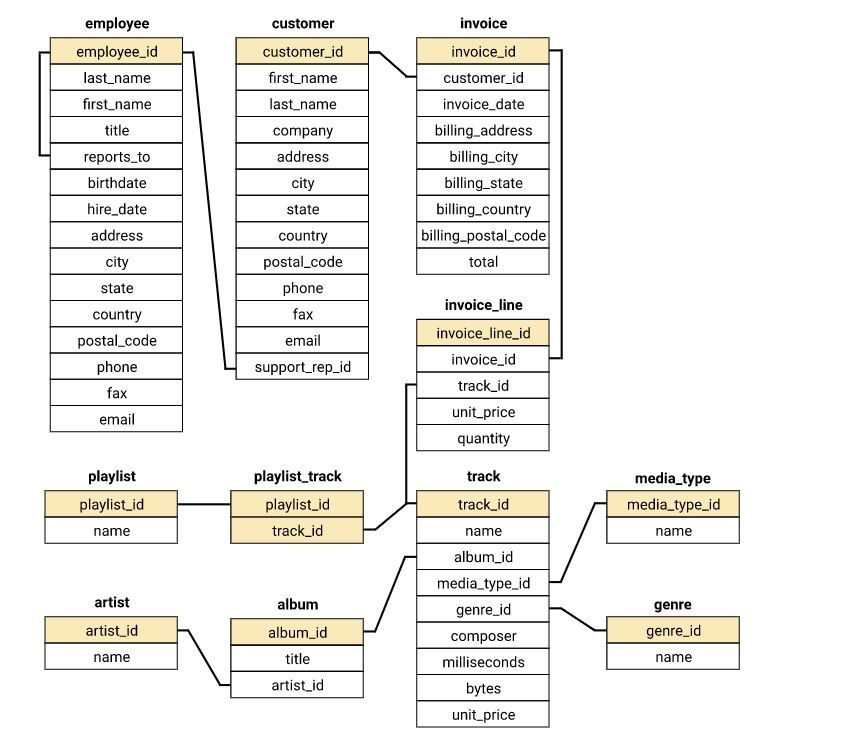

Lets connect to chinook database using below code

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

### THE FIRST PROBLEM GIVEN TO US
You'll need to write a query to find out which genres sell the most tracks in the USA, write up a summary of your findings, and make a recommendation for the three 
artists whose albums we should purchase for the store.

Write a query that returns each genre, with the number of tracks sold in the USA:

   --> in absolute numbers

   --> in percentages.

Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

NOTE: We use %%sql on every cell to run SQL queries

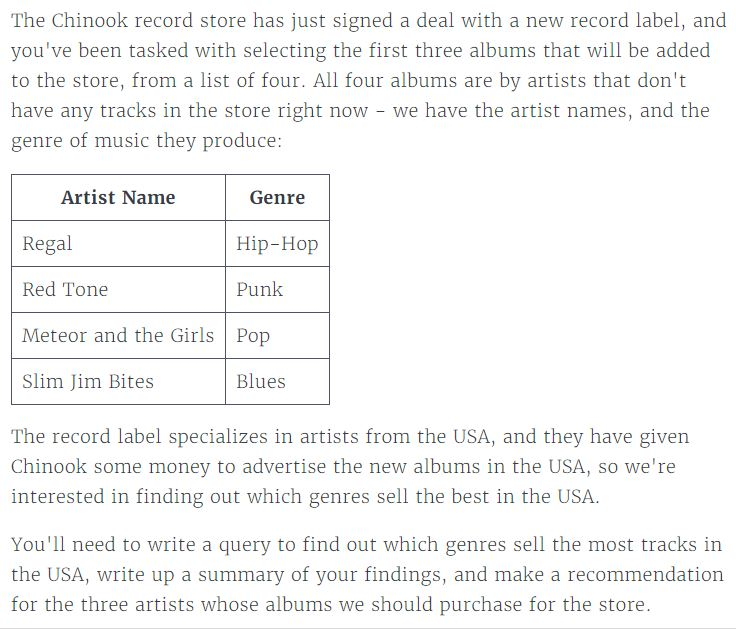

In [186]:
%%sql 
WITH count1 AS (SELECT ge.name genre_name,count(t.track_id) no_of_tracks ,c.country country 
                   FROM track t 
                      INNER JOIN genre ge ON ge.genre_id=t.genre_id
                          INNER JOIN invoice_line line ON line.track_id = t.track_id
                          INNER JOIN invoice iv ON iv.invoice_id = line.invoice_id
                       INNER JOIN customer c ON c.customer_id = iv.customer_id
                      WHERE country = 'USA'
                 GROUP BY 1
              ORDER BY 2 DESC)
SELECT count1.genre_name,count1.country,count1.no_of_tracks,ROUND((CAST(count1.no_of_tracks AS FLOAT)/1051)*100,4) percentage
FROM count1
GROUP BY 1 ORDER BY 3 DESC
LIMIT 10

 * sqlite:///chinook.db
Done.


genre_name,country,no_of_tracks,percentage
Rock,USA,561,53.3777
Alternative & Punk,USA,130,12.3692
Metal,USA,124,11.7983
R&B/Soul,USA,53,5.0428
Blues,USA,36,3.4253
Alternative,USA,35,3.3302
Pop,USA,22,2.0932
Latin,USA,22,2.0932
Hip Hop/Rap,USA,20,1.9029
Jazz,USA,14,1.3321


from the above we can conclude that 

red tone 

meteor and the girls

slim jim bites are recommended artists for purchasing the albums to store

## SECOND PROBLEM 

 Each customer for the Chinook store gets assigned to a sales support agent 

 within the company when they first make a purchase. You have been asked to 

 analyze the purchases of customers belonging to each employee to see if any 

 sales support agent is performing either better or worse than the others.

In [187]:
%%sql
WITH mass_maharaj AS 
                 (SELECT c.first_name || ' '|| c.last_name customer_name,c.customer_id,COUNT(iv.invoice_id) no_of_purchases,ROUND(SUM(iv.total),3) total_amount_for_purchases,e.employee_id, e.first_name || ' ' || e.last_name employee_name,e.hire_date
                  FROM customer c
                  INNER JOIN invoice iv on c.customer_id = iv.customer_id
                  INNER JOIN employee e on e.employee_id=c.support_rep_id
                  GROUP BY 1
                  ORDER BY 3 DESC)
SELECT UPPER(mj.employee_name) employee,ROUND(SUM(mj.total_amount_for_purchases), 2) total_purchases ,mj.hire_date date_hired
FROM mass_maharaj mj
GROUP BY 1

 * sqlite:///chinook.db
Done.


employee,total_purchases,date_hired
JANE PEACOCK,1731.51,2017-04-01 00:00:00
MARGARET PARK,1584.0,2017-05-03 00:00:00
STEVE JOHNSON,1393.92,2017-10-17 00:00:00


JANE PEACOCK is the best employee
and STEVE JOHNSON is performing less when compared to other two employees

## THIRD PROBLEM

Write a query that collates data on purchases from different countries.

Where a country has only one customer, collect them into an "Other" group.

The results should be sorted by the total sales from highest to lowest, with the "Other" group at the 
very bottom.

For each country, include:

   total number of customers

   total value of sales

   average value of sales per customer

   average order value





In [188]:
%%sql
WITH nc1 AS (SELECT (CASE  WHEN ( SELECT COUNT(*)
                     FROM customer
                     WHERE country = c.country)=1 THEN 'Others'
                     ELSE c.country
                     END) AS country , COUNT(distinct c.customer_id) customers , ROUND(SUM(iv.total),4) total_sales , count (distinct iv.invoice_id ) count_invoice_id
             FROM customer c
             INNER JOIN invoice iv ON iv.customer_id = c.customer_id
             GROUP BY 1 ORDER BY 2 DESC)
SELECT country , customers , total_sales , ROUND(total_sales / customers, 4) AS avg_sales_per_customer , ROUND((total_sales/count_invoice_id ),4) avg_order
FROM (SELECT nc1.* , CASE WHEN nc1.country='Others' THEN 1 
                     ELSE 0
                     END AS sort
     FROM nc1
     )
ORDER BY sort ASC

 * sqlite:///chinook.db
Done.


country,customers,total_sales,avg_sales_per_customer,avg_order
USA,13,1040.49,80.0377,7.9427
Canada,8,535.59,66.9488,7.0472
France,5,389.07,77.814,7.7814
Brazil,5,427.68,85.536,7.0111
Germany,4,334.62,83.655,8.1615
United Kingdom,3,245.52,81.84,8.7686
Portugal,2,185.13,92.565,6.3838
India,2,183.15,91.575,8.7214
Czech Republic,2,273.24,136.62,9.108
Others,15,1094.94,72.996,7.4486


The above are the results for the 3rd problem 

## FOURTH PROBLEM

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

    Number of invoices

    Percentage of invoices

Write one to two sentences explaining your findings, and making a prospective recommendation on whether the Chinook store should continue to buy full albums from record companies

In [303]:
%%sql
WITH invoice_tracks AS
  (
    SELECT 
      il.invoice_id,
      COUNT(DISTINCT(il.track_id)) AS unique_tracks,
      t.album_id
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    GROUP BY invoice_id, album_id
  ),
  
  album_tracks AS
    (
    SELECT
      album_id,
      COUNT(DISTINCT(track_id)) AS number_of_tracks
    FROM track
    GROUP BY album_id
    HAVING number_of_tracks > 2
  ),
    album_purchases AS
     (
    SELECT
      it.invoice_id,
      it.unique_tracks,
      at.*,
      CASE
        WHEN unique_tracks = number_of_tracks THEN 'yes'
        ELSE 'no'
      END AS album_purchase
    FROM invoice_tracks it
    INNER JOIN album_tracks at ON at.album_id = it.album_id
  )
SELECT 
  album_purchase,
    COUNT(DISTINCT(invoice_id)) AS invoices,
    ROUND(CAST(COUNT(DISTINCT(invoice_id)) as float) / (SELECT COUNT(DISTINCT(invoice_id)) FROM album_purchases) * 100, 2) AS percentage
FROM album_purchases
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,invoices,percentage
no,500,81.83
yes,111,18.17
